## Titanic - ML1 lesson 2 
### 18th March 2018


## Random Forest Model Interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics



In [3]:
set_plot_sizes(12, 14, 16)

## Load in our data from last session


In [4]:
PATH = "data/titanic"

In [5]:
!ls tmp

keep_cols.npy  titanic_procdfd_raw  titanic_raw_cats


In [6]:
PATH = "data/titanic/"
df_raw = pd.read_feather('tmp/titanic_raw_cats')
df, y, nas = proc_df(df_raw, 'Survived')

In [7]:
df.describe()


,PassengerId,Pclass,Name,Married,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,446.000000,0.720539,1.647587,29.361582,0.523008,0.381594,339.528620,32.204208,17.629630,2.529742
std,257.353842,0.836071,257.353842,0.448987,0.477990,13.019697,1.102743,0.806057,200.850657,49.693429,38.140335,0.800254
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,223.500000,0.000000,1.000000,22.000000,0.000000,0.000000,159.500000,7.910400,0.000000,2.000000
50%,446.000000,3.000000,446.000000,1.000000,2.000000,28.000000,0.000000,0.000000,338.000000,14.454200,0.000000,3.000000
75%,668.500000,3.000000,668.500000,1.000000,2.000000,35.000000,1.000000,0.000000,520.500000,31.000000,0.000000,3.000000
max,891.000000,3.000000,891.000000,1.000000,2.000000,80.000000,8.000000,6.000000,681.000000,512.329200,147.000000,3.000000


In [8]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

# n_valid = 418 #same as Kaggle's test set size
n_valid = 100 #smaller validation set to provide more training data
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
x_train, x_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

raw_train.shape, x_train.shape, y_train.shape, x_valid.shape, y_valid.shape


((791, 13), (791, 13), (791,), (100, 13), (100,))

In [9]:
df.tail()

,PassengerId,Pclass,Name,Married,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
886,887,2,549,0,2,27.0,0,0,102,13.00,0,3,False
887,888,1,304,0,1,19.0,0,0,15,30.00,31,3,False
888,889,3,414,0,1,28.0,1,2,676,23.45,0,3,True
889,890,1,82,1,2,26.0,0,0,9,30.00,61,1,False
890,891,3,221,1,2,32.0,0,0,467,7.75,0,2,False


## functions

In [10]:
def rmse(pred,actual): return math.sqrt(((pred-actual)**2).mean())

In [11]:
def print_score(m):
    result = [f'rmse train: {rmse(m.predict(x_train), y_train)} Training set size: {len(y_train)}', 
              f'\nrmse validation: {rmse(m.predict(x_valid), y_valid)} Validation set size: {len(y_valid)}',
              f'\nRsquared train: {m.score(x_train, y_train)}',
              f'\nRSquared valid: {m.score(x_valid, y_valid)}']
    print(result[0], result[1], result[2], result[3])
    if hasattr(m, 'oob_score_'):
        result.append(f'OOB: {m.oob_score_}')
        print(result[4])

In [12]:
def custom_print_score(m, x_t, y_t):
    result = [f'rmse train: {rmse(m.predict(x_t), y_t)} Total set size: {len(y_t)}', 
              f'\nRsquared train: {m.score(x_t, y_t)}']
    print(result[0], result[1])
    if hasattr(m, 'oob_score_'):
        result.append(f'OOB: {m.oob_score_}')
        print(result[2])

In [13]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, 
                           "display.max_columns", 1000):
        display(df)

## Confidence based on tree variance
For model interpretation, there's no need to use the full dataset on each tree - using a subset will be faster, and also provide better interpretability, since an overfit model will not provide much variance across trees.

In [14]:
df.shape

(891, 13)

Picks 800 out of the 891 samples in the training set each time we make a tree - this way each tree is trained on a different subset of the data and the trees should be less correlated with each other and less predictive individually, but over a large number their errors should average to zero. Subtly different to bootstrapping where a number of samples equal to the sample size are picked with replacement for each tree. 

In [15]:
set_rf_samples(800)
#reset_rf_samples()

In [16]:

#Training set and validation set scores
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x_train, y_train)
print_score(m)

rmse train: 0.22847425917629122 Training set size: 791 
rmse validation: 0.33081606723910545 Validation set size: 100 
Rsquared train: 0.7799282193041828 
RSquared valid: 0.5250031669116825
OOB: 0.4522995349426986


In [17]:
# Out of bag scores only - uses entire dataset to train. 
m_all = RandomForestRegressor(n_estimators=40,  min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m_all.fit(df, y)
custom_print_score(m_all, df, y)

rmse train: 0.2358756926990633 Total set size: 891 
Rsquared train: 0.7647534111631651
OOB: 0.47179808478811835


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of this estimate? One way is to use the standard deviation of predictions, instead of just the mean. This tells us the <em>relative</em> confidence of predictions  - that is , for rows where the trees give very different results, compared to cases where they are more consistent. 

Some passenger predictions will be made up from trees which all predict a similar result, and some passenger predictions will be made from trees with wildly varying results - the standard deviation of the outcome reflects whether the trees were in agreement for that passenger or not. 


Using the same example as in the last lesson when we looked at bagging:

In [18]:
passenger=4
%time preds = np.stack([t.predict(x_valid) for t in m.estimators_])
np.mean(preds[:,passenger]), np.std(preds[:, passenger])
# Take the mean of all the predictions for one passenger, Take the sd of all the predictions for one passenger. 

CPU times: user 156 ms, sys: 6.92 ms, total: 162 ms
Wall time: 155 ms


(0.044226190476190474, 0.12430975809665903)

In [19]:
preds.shape # 40 averaged trees, for 100 passengers in the validation set

(40, 100)

We are looking at the average of 40 trees' predictions for a single passenger's survival chances. 

When we use python to loop through trees in a list comprehension, we are calculating each tree in series, which is slow! We can use parallel processing to speed things up:


In [20]:
passenger=5
def get_preds(t): return t.predict(df)
%time preds = np.stack(parallel_trees(m_all, get_preds))
np.mean(preds[:,passenger]), np.std(preds[:,passenger])

CPU times: user 69 ms, sys: 147 ms, total: 216 ms
Wall time: 298 ms


(0.13672619047619047, 0.24735312959401715)

It is possible that splitting the job into parts for parallel processing takes more time than just running the operation in series for a small dataset. 

In this case my laptop has 4 cores, and using all 4 cores causes the operation to run more slowly since the data needs separating into 4 chunks first. Running the data on one just core or 3 cores seems optimal for this small dataset. 

We can see that different trees give different estimates in this model - in order to see how prediction confidence varies, we can add this into our dataset: 

In [21]:
x = df_raw.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

In [22]:
x.describe()

,PassengerId,Survived,Pclass,Married,Age,SibSp,Parch,Fare,pred_std,pred
count,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.720539,29.699118,0.523008,0.381594,32.204208,0.215774,0.387445
std,257.353842,0.486592,0.836071,0.448987,14.526497,1.102743,0.806057,49.693429,0.104736,0.358767
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.142139,0.070952
50%,446.000000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.211390,0.227946
75%,668.500000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.304988,0.762872
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,0.430530,1.000000


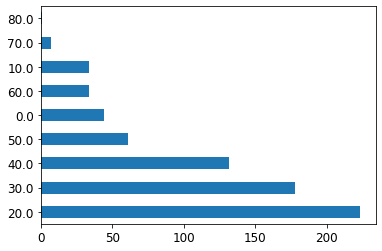

In [23]:

x.Age.round(-1).value_counts().plot.barh()

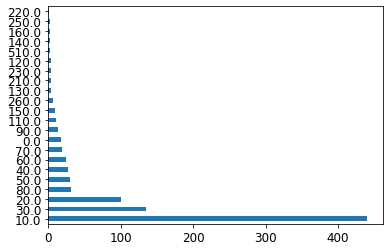

In [24]:
x.Fare.round(-1).value_counts().plot.barh()

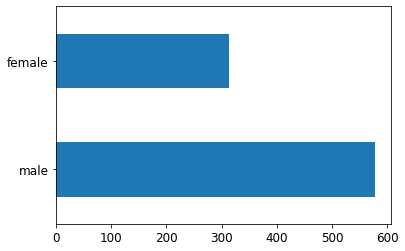

In [25]:
x.Sex.value_counts().plot.barh()

## Male = 2 Female = 1

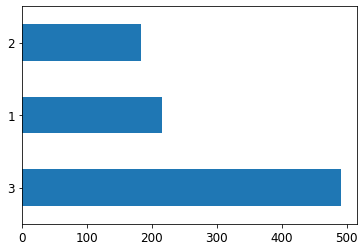

In [26]:
x.Pclass.value_counts().plot.barh()

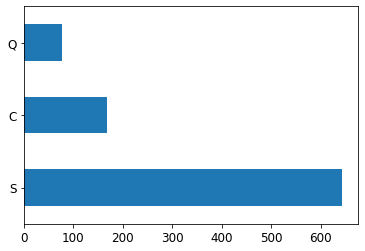

In [27]:
x.Embarked.value_counts().plot.barh()

In [28]:

fields = ['Sex', 'Survived', 'pred', 'pred_std']
sex_summ = x[fields].groupby('Sex', as_index=False).mean()
display_all(sex_summ)

,Sex,Survived,pred,pred_std
0,female,0.742038,0.739314,0.217462
1,male,0.188908,0.195959,0.214856


Standard deviations for sex as a predictor of survival are 0.26F and 0.29M for female and male when used on the split sample validation set of 418 passengers. If we use a smaller validation set and larger training set 791 train 100 valid, the standard deviation improves and we have 0.24F and 0.27M, still not huge but its an improvement. 

Finally if we use all of the data to train the model and do away with the validation set we have a standard deviation of 0.23F and 0.22M.

In [29]:
df.shape


(891, 13)

In [30]:


##enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
##enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

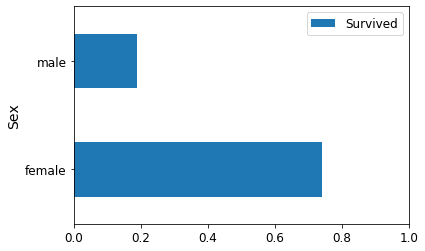

In [31]:
sex_summ.plot('Sex', 'Survived', 'barh', xlim=(0,1))

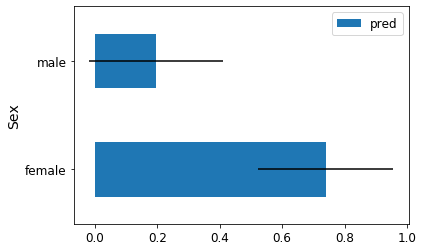

In [32]:
sex_summ.plot('Sex', 'pred', 'barh', xerr=('pred_std'))

maleness or femaleness isn't a good predictor using this model - we could try to train the model with a different set of samples and use the out of bag score for more accuracy. 

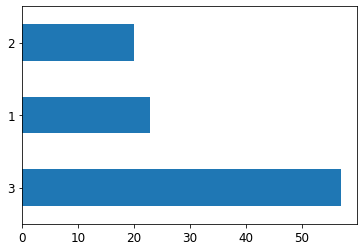

In [33]:
raw_valid.Pclass.value_counts().plot.barh()


In [34]:
flds = ['Pclass', 'Survived', 'pred', 'pred_std']
pclass_summ = x[flds].groupby('Pclass', as_index=False).mean()
pclass_summ

,Pclass,Survived,pred,pred_std
0,1,0.629630,0.632729,0.227314
1,2,0.472826,0.471857,0.196868
2,3,0.242363,0.247906,0.217783


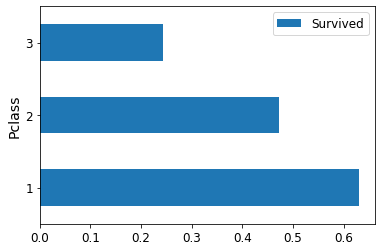

In [35]:
# pclass_summ = pclass_summ[~pd.isnull(pclass_summ.Survived)]
pclass_summ.plot('Pclass', 'Survived', 'barh')

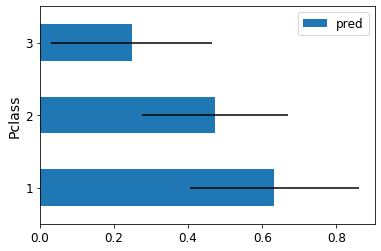

In [36]:
pclass_summ.plot('Pclass', 'pred', 'barh', xerr='pred_std')

The predictions are nearly exactly right, but the error bars are quite wide. Why is this?

In [37]:
(pclass_summ.pred_std/pclass_summ.pred).sort_values(ascending=False)

2    0.878488
1    0.417220
0    0.359260
dtype: float64

##  Feature Importance
It's not normally enough just to know that a model can make accurate predictions - we also want to know how its making the predictions. The most important way to see this is with feature importance. 

In [38]:
feature_importance = rf_feat_importance(m, df);
feature_importance[:10]

,cols,imp
4,Sex,0.287571
8,Ticket,0.120060
9,Fare,0.115662
2,Name,0.089376
0,PassengerId,0.074992
5,Age,0.074679
3,Married,0.072788
1,Pclass,0.061357
10,Cabin,0.051131
6,SibSp,0.027231


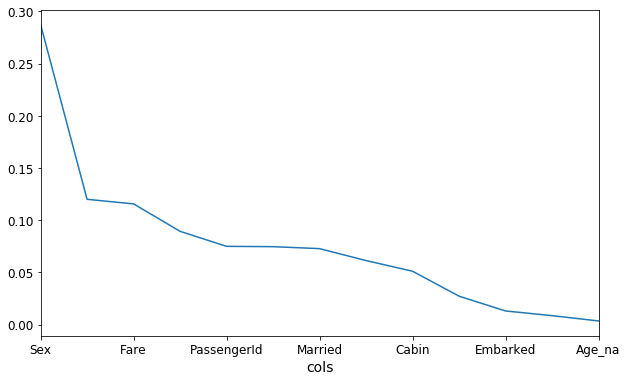

In [39]:
feature_importance.plot('cols', 'imp', figsize=(10,6), legend=False);

In [40]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

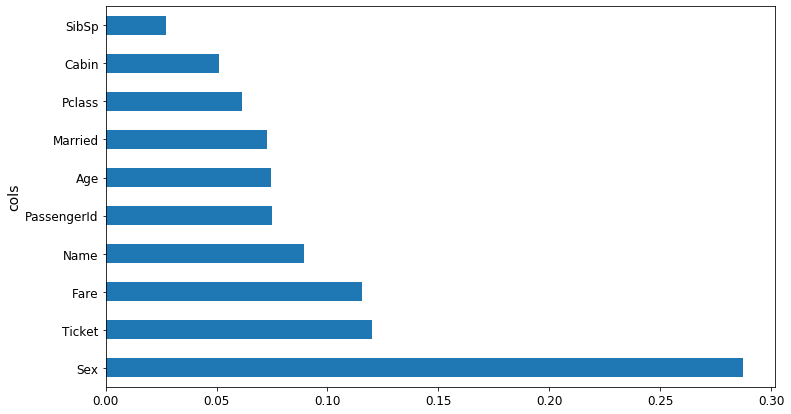

In [41]:
plot_fi(feature_importance[:10])

In [42]:
print(df['Age_na'].sum())
df.head(10)


177


,PassengerId,Pclass,Name,Married,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1,3,109,1,2,22.0,1,0,524,7.2500,0,3,False
1,2,1,191,1,1,38.0,1,0,597,71.2833,82,1,False
2,3,3,354,0,1,26.0,0,0,670,7.9250,0,3,False
3,4,1,273,1,1,35.0,1,0,50,53.1000,56,3,False
4,5,3,16,1,2,35.0,0,0,473,8.0500,0,3,False
5,6,3,555,1,2,28.0,0,0,276,8.4583,0,2,True
6,7,1,516,1,2,54.0,0,0,86,51.8625,130,3,False
7,8,3,625,0,2,2.0,3,1,396,21.0750,0,3,False
8,9,3,413,1,1,27.0,0,2,345,11.1333,0,3,False
9,10,2,577,1,1,14.0,1,0,133,30.0708,0,1,False


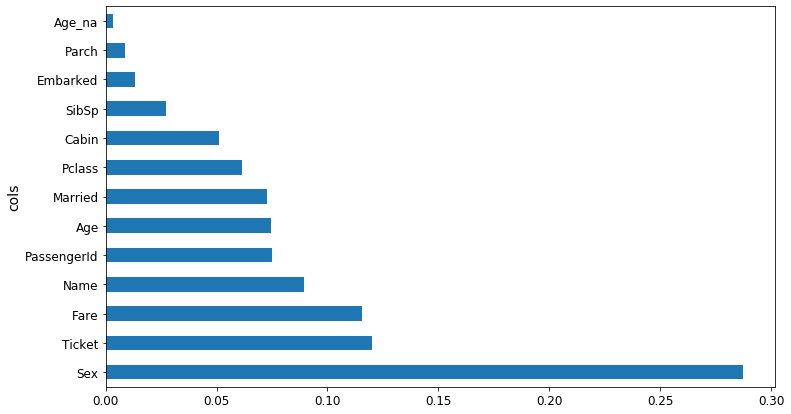

In [43]:
plot_fi(feature_importance)

It is clear that gender is the most important predictor of survival, but what about the other variables? The independent variables PassengerId, Fare, Age, Name and Ticket all seem to have some contribution, but why? One would expect the age to come into play but not necessarily the name. We can remove the least important contributors to try to reduce noise, provide more splitting opportunities and to reduce colinearity. 

In [44]:
to_keep = feature_importance[feature_importance.imp>0.05].cols;
to_keep

4             Sex
8          Ticket
9            Fare
2            Name
0     PassengerId
5             Age
3         Married
1          Pclass
10          Cabin
Name: cols, dtype: object

In [45]:
# m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
#                           n_jobs=-1, oob_score=True)
# m.fit(X_train, y_train)
# print_score(m)

In [46]:
df_keep = df[to_keep].copy()
m=RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df_keep, y)
custom_print_score(m, df_keep, y)

rmse train: 0.23676193338525467 Total set size: 891 
Rsquared train: 0.762982336239744
OOB: 0.47788550901487725


In [47]:
df_keep.shape

(891, 9)

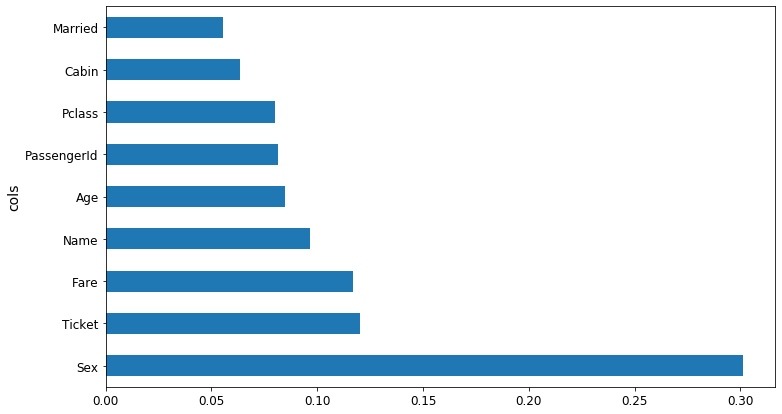

In [48]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

## One_hot encoding
proc_df's optional max_n_cat argument will turn some categorical variables into new columns. 

For example, the column <b>Pclass</b> which has 3 categories, <b>1, 2, 3</b>

gets turned into 3 new  categories <b>Pclass_1, Pclass_2, Pclass_3 </b>

and the column Pclass gets removed. 

This could be useful when a single category has much more importance than the others - it would be instantly accessible by the decision tree, and would not waste valuable splits trying to identify the valuable category. 

It will only happen for columns whose number of categories is no bigger than the value of
<b>max_n_cat</b> argument

now some of these columns may prove to have more important features than in the earlier situation where all the categories were in one column.

In [49]:
# train_cats(df_raw)
## df_raw already trained cats in lesson 1

df_2, y, nas = proc_df(df_raw, 'Survived', max_n_cat=6)


In [50]:
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(df_2, y)
custom_print_score(m, df_2, y)

rmse train: 0.2321159233448759 Total set size: 891 
Rsquared train: 0.7721931250516546
OOB: 0.4784001038678406


In [51]:
df_raw.tail()


,PassengerId,Survived,Pclass,Name,Married,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",0,male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",0,female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",1,male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",1,male,32.0,0,0,370376,7.75,NaN,Q


In [52]:
df_2.head()

,PassengerId,Pclass,Name,Married,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_na,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,3,109,1,22.0,1,0,524,7.2500,0,False,0,1,0,0,0,1,0
1,2,1,191,1,38.0,1,0,597,71.2833,82,False,1,0,0,1,0,0,0
2,3,3,354,0,26.0,0,0,670,7.9250,0,False,1,0,0,0,0,1,0
3,4,1,273,1,35.0,1,0,50,53.1000,56,False,1,0,0,0,0,1,0
4,5,3,16,1,35.0,0,0,473,8.0500,0,False,0,1,0,0,0,1,0


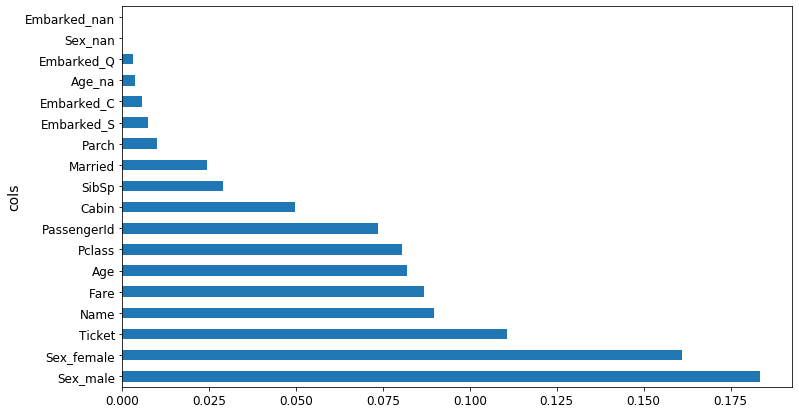

In [53]:
fi = rf_feat_importance(m, df_2)
plot_fi(fi)

## Removing redundant features
one thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Lets try to remove some redundant features.

In [54]:
from scipy.cluster import hierarchy as hc

<b>Spearman's rank</b> is used to find whether two variables are correlated or not - it will show both linear and exponential correlations - provided the graph is monotonic/ ramp like and not a semicircle or sine wave. It works by taking the rank of each data point and finding correlation between the x and y ordering of points rather than the value described by those points. 

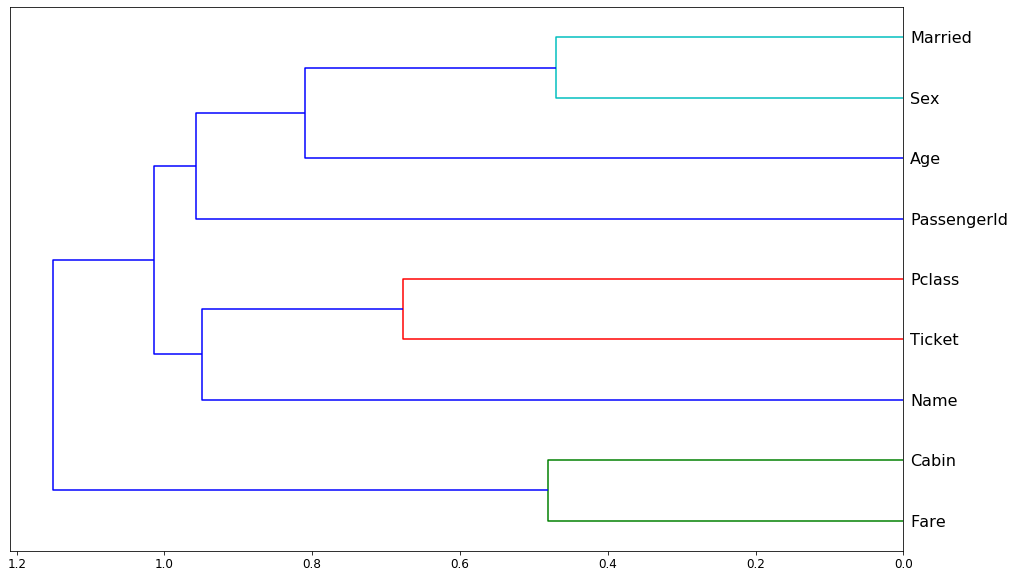

In [55]:
correlation = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-correlation)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 10))
dendogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

<b>There's a correlation between class and ticket price.</b> This makes sense - higher social class will afford higher ticket prices. We can see whether removing one of these variables improves the RSquared of our model

It also looks as though married status and Sex are related


In [56]:
# def get_oob(df):
#     m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
#     x, _ = split_vals(df, n_trn)
#     m.fit(x, y_train)
#     return m.oob_score_

## Modified to use entire dataset since the dataset is small. 

def get_oob(df):
    m = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
    m.fit(df, y) # training the model on the entire set of samples
    return m.oob_score_
    
    
    
    

In [57]:
get_oob(df_keep)

0.4841000537286184

<b>0.47 is our baseline</b>
Now we try removing each variable one at a time

In [58]:
df['PassengerId']

0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: PassengerId, Length: 891, dtype: int64

In [59]:
for c in to_keep:
    print(c, get_oob(df_keep.drop(c, axis=1)))

Sex 0.29102683351916137
Ticket 0.46250837649238385
Fare 0.460812617385704
Name 0.466676934441953
PassengerId 0.486262675017314
Age 0.47106283035086216
Married 0.4775746644320238
Pclass 0.44026767491660335
Cabin 0.47339741936272817


It looks like we can remove the passenger id column. this could be becuse PassengerId is correlated with another independent variable, or because it is totally meaningless in the database and takes up valuable splits. 

Removing the Sex column reduces the predictivity of the model significantly - if we were to do any data cleaning we should focus our efforts there. 

In [60]:
to_drop =  [ 'PassengerId']

In [61]:
get_oob(df_keep.drop(to_drop, axis=1))

0.4852183687680065

This is an improvement  - out of bag RSquared score of 0.48 by dropping PassengerId. let's use this dataframe from here.

In [62]:
df_keep.drop(to_drop, axis=1, inplace=True)


Since we have removed passenger id, we will need to remember to add the column to the output when submitting our results. 
<br>
<b>Passenger id = row number plus 1</b> 

In [63]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [64]:
keep_cols = np.load('tmp/keep_cols.npy')

In [65]:
keep_cols

array(['Sex', 'Ticket', 'Fare', 'Name', 'Age', 'Married', 'Pclass', 'Cabin'], dtype=object)

In [66]:
df_keep = df[keep_cols]

In [67]:
df_keep

,Sex,Ticket,Fare,Name,Age,Married,Pclass,Cabin
0,2,524,7.2500,109,22.0,1,3,0
1,1,597,71.2833,191,38.0,1,1,82
2,1,670,7.9250,354,26.0,0,3,0
3,1,50,53.1000,273,35.0,1,1,56
4,2,473,8.0500,16,35.0,1,3,0
...,...,...,...,...,...,...,...,...
886,2,102,13.0000,549,27.0,0,2,0
887,1,15,30.0000,304,19.0,0,1,31
888,1,676,23.4500,414,28.0,0,3,0
889,2,9,30.0000,82,26.0,1,1,61


Having worked out the important features on a subset of the samples, we could now use this reduced set of features on the entire dataset

In [68]:
# reset_rf_samples()
set_rf_samples(800)

Keeping a few rows unavailable for each decision might make each tree less predictive individually but averaging across a large number should zero out these errors. 

# Train a new model on the combined set training and validation data with reduced number of columns. 
Hyperparameter tuning and feature analysis should all have been done on the validation set. We combine the two and repeat the model training process exactly before running on the training set. This allows us to see if we overfit to the validation set, and provides more data to train a more accurate model. 

We will not be able to get a validation score from this model since the validation set was included in training the model.

Be careful not to overfit to the training set.

In [69]:
m = RandomForestRegressor(n_estimators = 400, min_samples_leaf = 2, max_features = 0.5, n_jobs=-1, oob_score=True)
m.fit(df_keep,y)
custom_print_score(m, df_keep, y)

rmse train: 0.20505593273163866 Total set size: 891 
Rsquared train: 0.8222123311862453
OOB: 0.49257085370129805


## Partial Dependence

In [70]:
from pdpbox import pdp
from plotnine import *

In [71]:
set_rf_samples(800)

This next analysis will be a little easier if we open up the 1 hot encoded categorical variables, so let's load them up again:

In [72]:
df2, y2, nas = proc_df(df_raw, 'Survived', max_n_cat = 6)
x_train, x_valid = split_vals(df2, n_trn) # use this on large datasets
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=2, max_features=0.5, n_jobs=-1)
m.fit(df2,y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

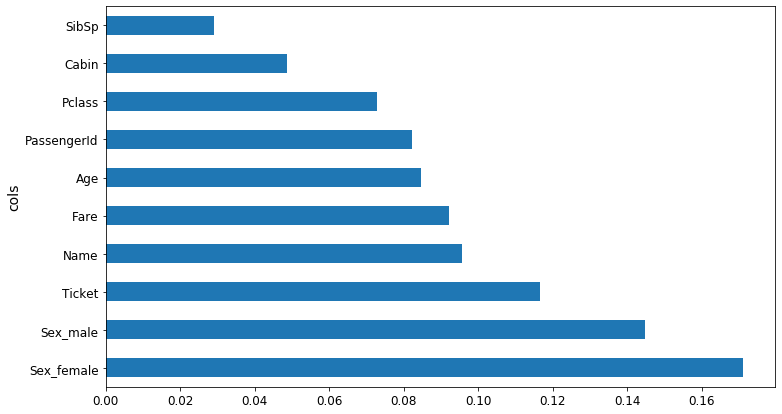

In [73]:
plot_fi(rf_feat_importance(m, df2)[:10])

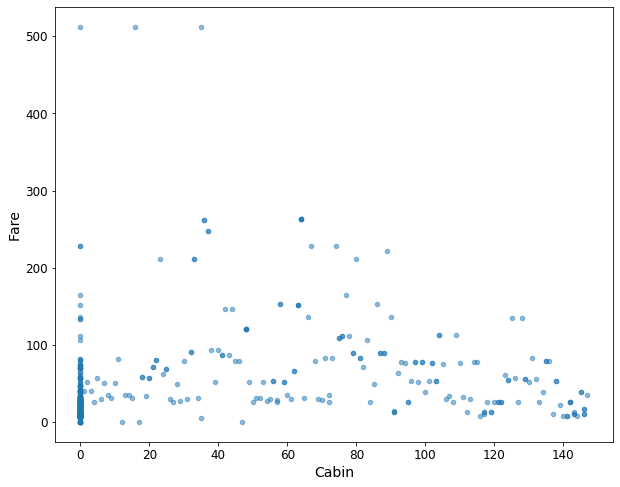

In [74]:
df2.plot('Cabin', 'Fare', 'scatter', alpha = 0.5, figsize = (10,8));

lots of the cabin fields were blank.

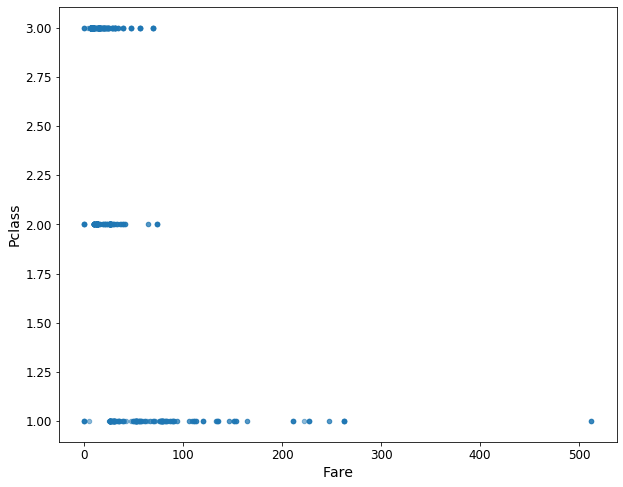

In [75]:
df2.plot('Fare', 'Pclass', 'scatter', alpha = 0.5, figsize = (10,8))

The higher fares were all paid by 1st class passengers. 

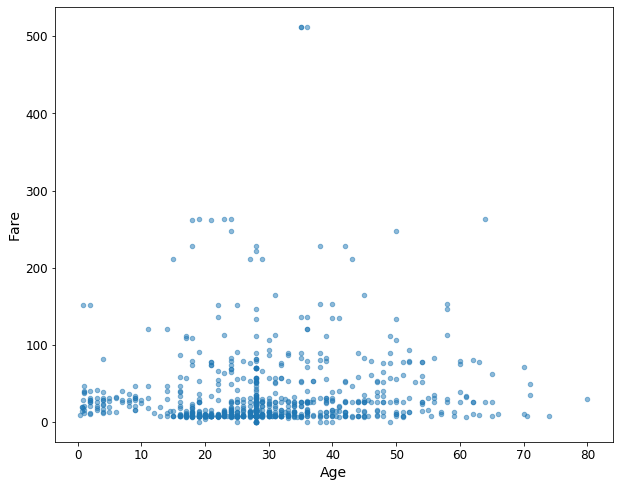

In [76]:
df2.plot('Age', 'Fare', 'scatter', alpha = 0.5, figsize = (10,8))

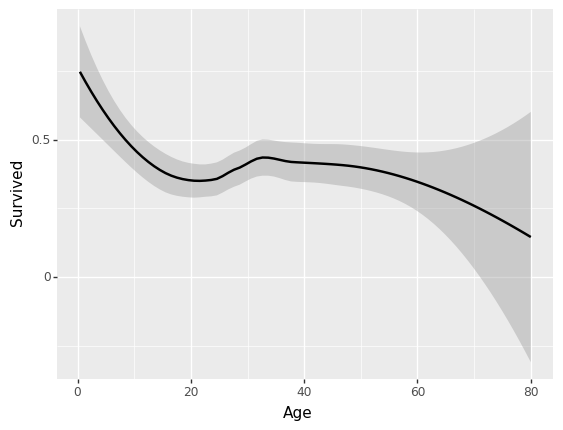

<ggplot: (-9223363248620392104)>

In [77]:
ggplot(df_raw, aes('Age','Survived'))+stat_smooth(se=True, method='loess')

The chance of survival is higher for younger people and lower for older people, but the confidence drops for ages above 60 since there were only a few passengers over 60 included in the data. The median age was 28.

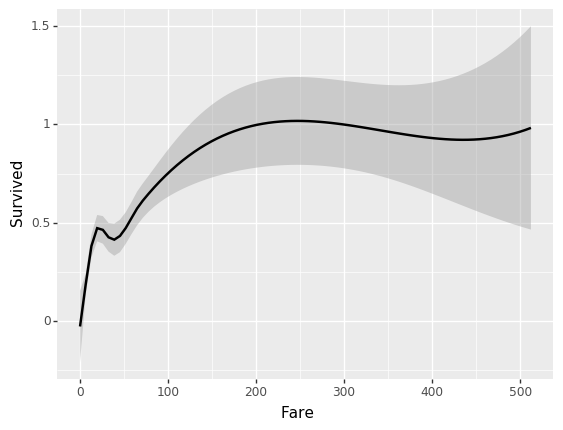

<ggplot: (-9223363248620393875)>

In [78]:
ggplot(df_raw, aes('Fare','Survived'))+stat_smooth(se=True, method='loess')

In [79]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, df_2, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, center=False, cluster=clusters is not None, n_cluster_centers=clusters)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


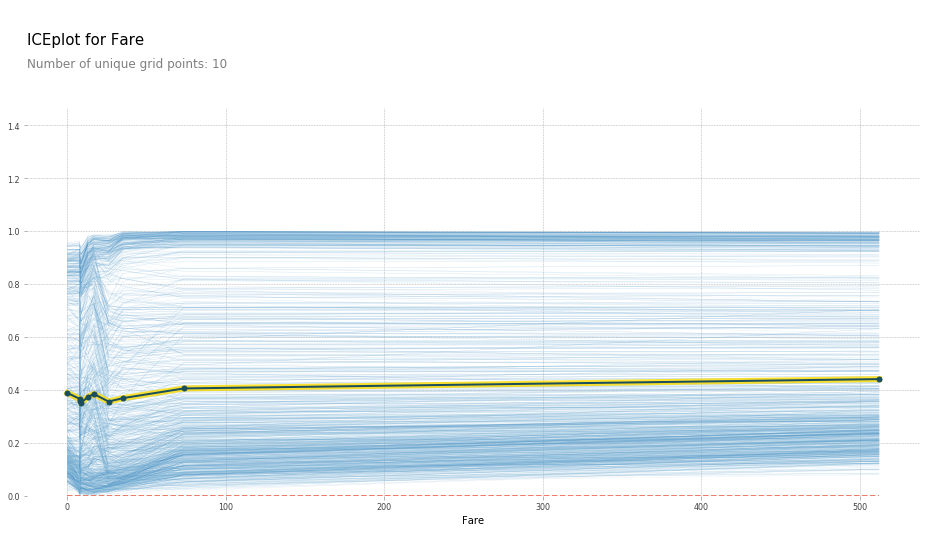

In [80]:
plot_pdp('Fare')

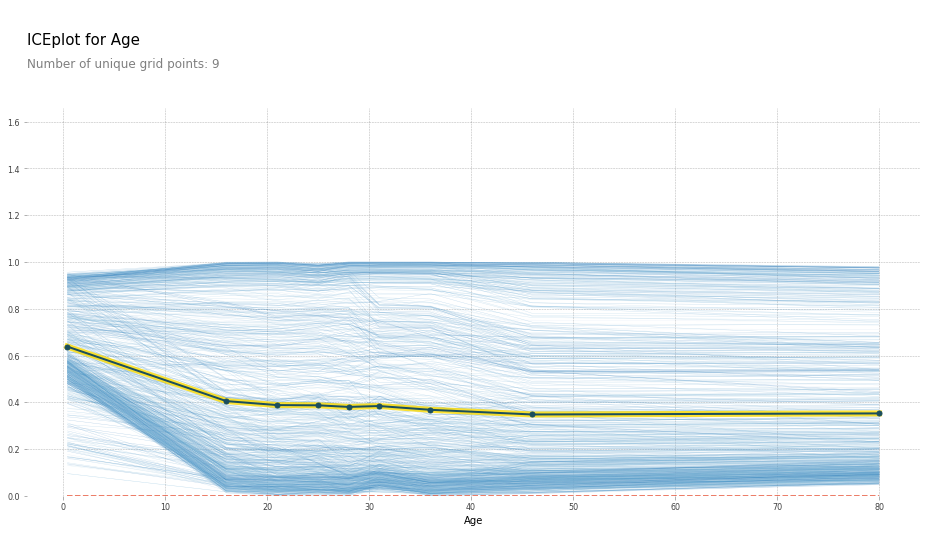

In [81]:
plot_pdp('Age')

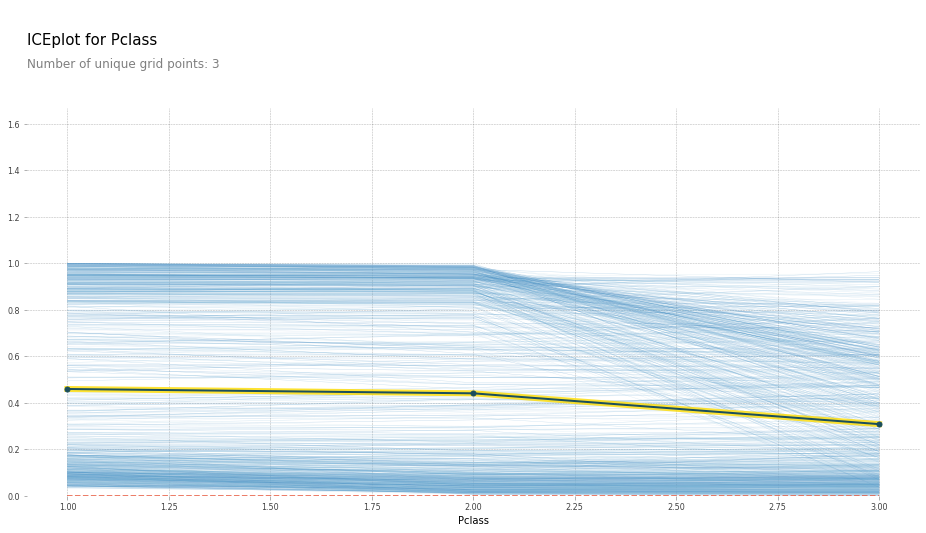

In [82]:
plot_pdp('Pclass')

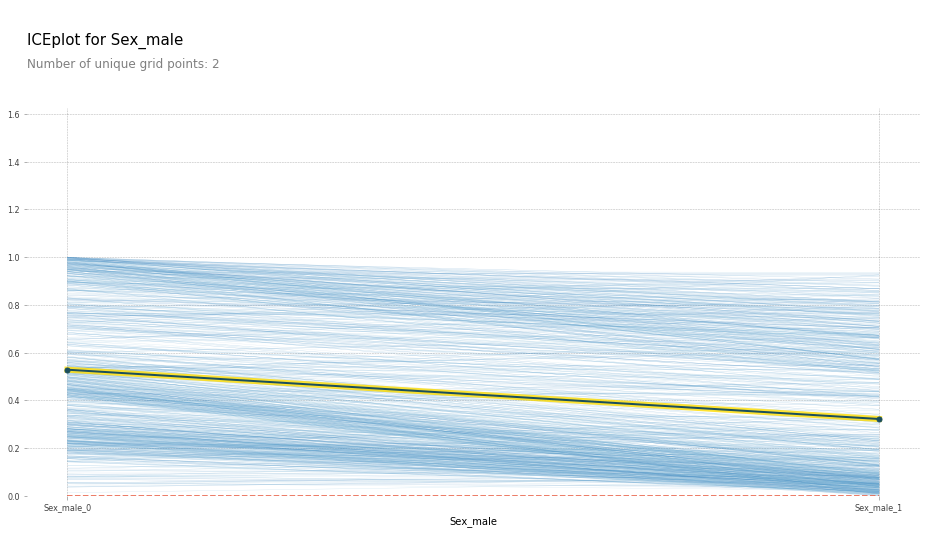

In [83]:
plot_pdp('Sex_male')

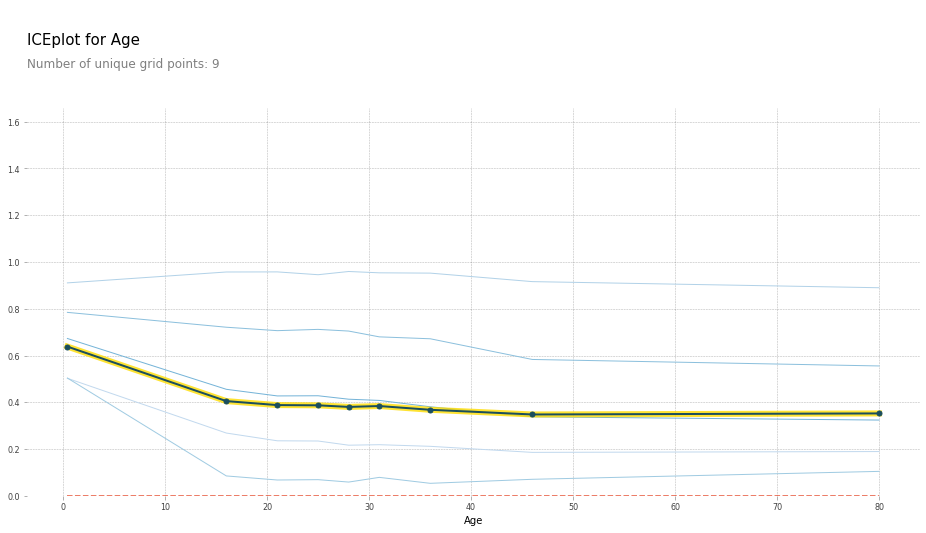

In [84]:
plot_pdp('Age', clusters=5)

The survival chances drop significantly for people over age 15 

## PDP Interaction plot for gender vs age
Below is an interesting interaction showing how for people under 20, age is the most relevant factor in survival chance, and for people over 20 Gender is more relevantm with women being more likely to survive. 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


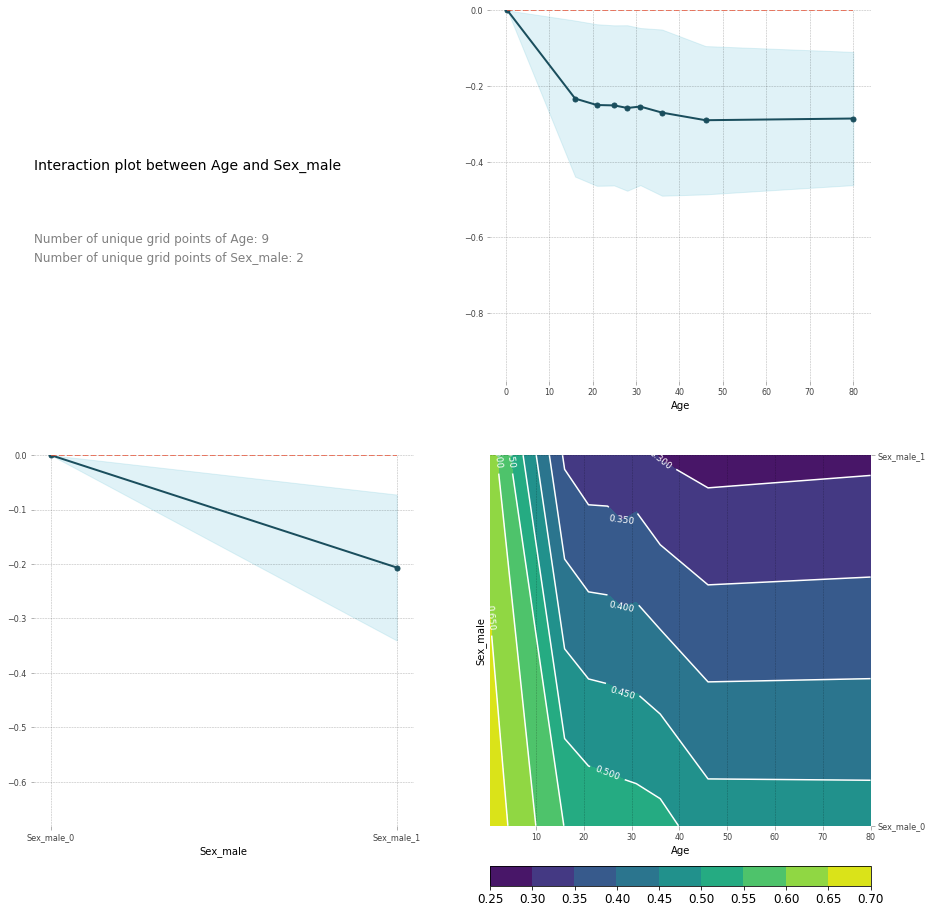

In [85]:
feats = ['Age', 'Sex_male']
p = pdp.pdp_interact(m,df_2, feats)
pdp.pdp_interact_plot(p, feats)


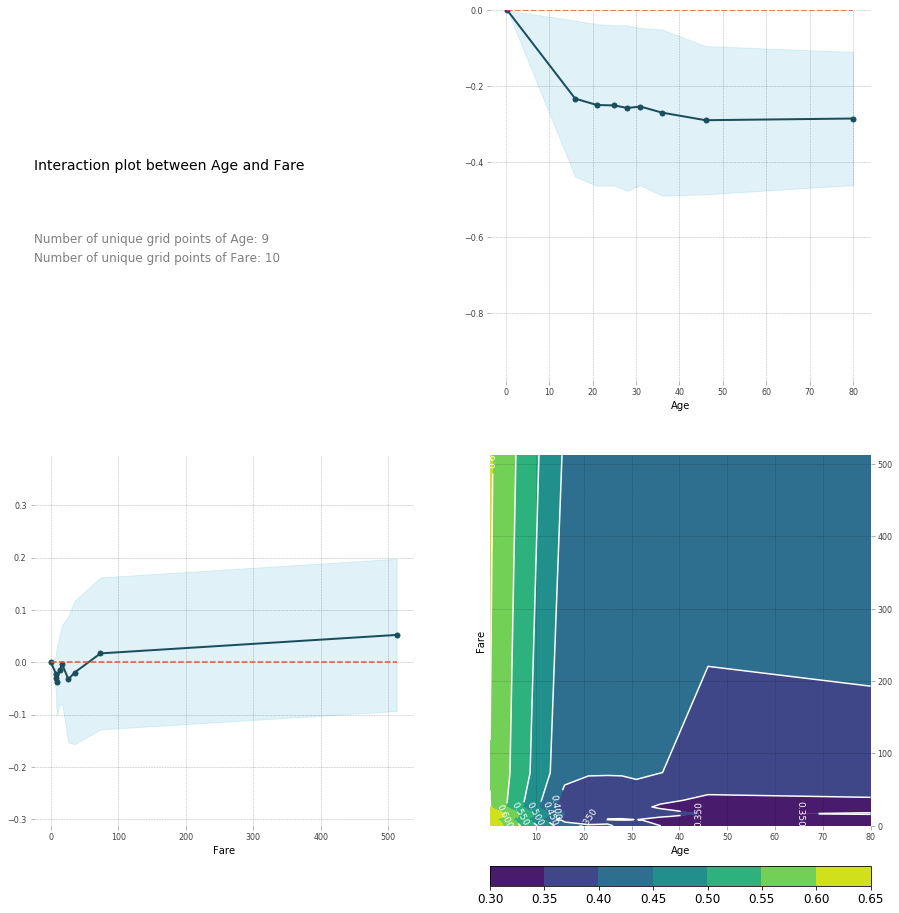

In [86]:
feats=['Age', 'Fare']
p=pdp.pdp_interact(m,df_2,feats)
pdp.pdp_interact_plot(p, feats)

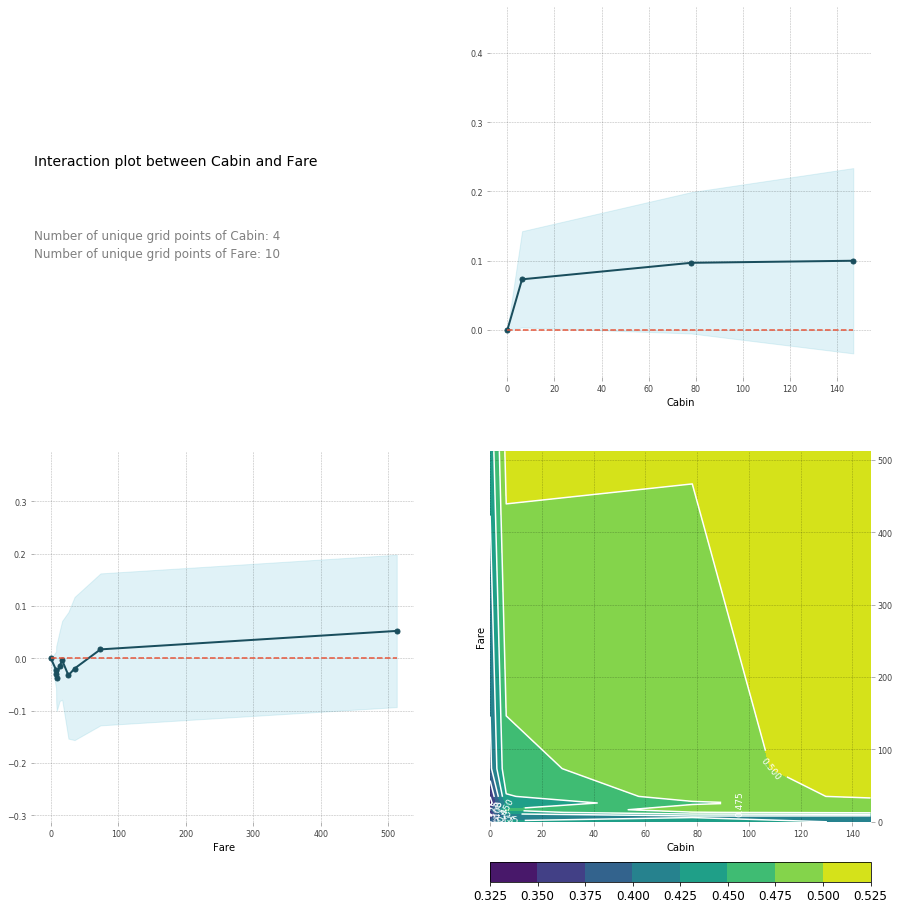

In [87]:
feats=['Cabin', 'Fare']
p=pdp.pdp_interact(m,df_2,feats)
pdp.pdp_interact_plot(p, feats)

This plot shows that for people under the age of 15 there was no correlation between fare paid and chance of survival. Younger people were more likely to survive across all fares. For older passengers there is only weak correlation andn very little data for the higher fares paid. 

Note: if the PDP interaction plots do not display properly this may be because the library was updated since these video lectures were recorded - check https://forums.fast.ai/t/pbpbox-error-on-pdp-interact-plot/28468/8 for a fix. 

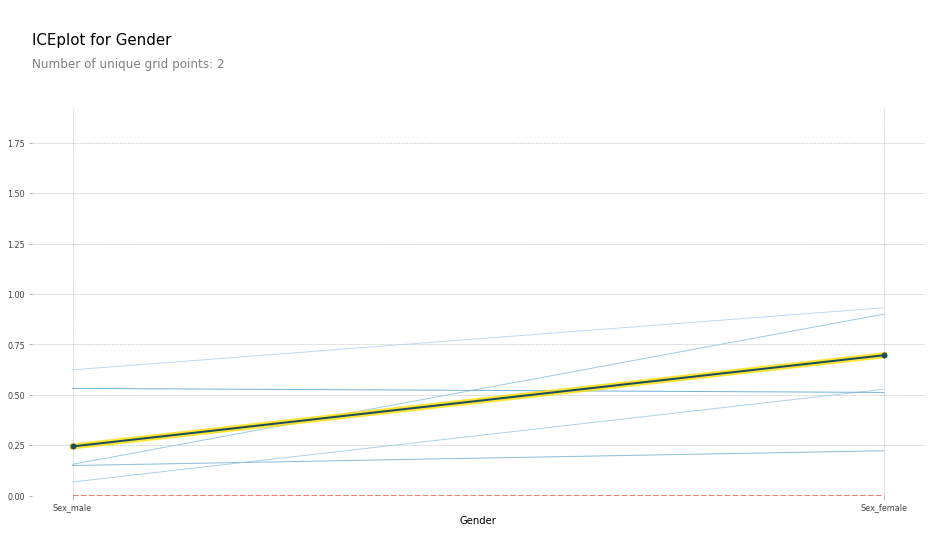

In [88]:
plot_pdp(['Sex_male', 'Sex_female'], 5, 'Gender')

The model shows that there is a higher chance of female survival than male. 

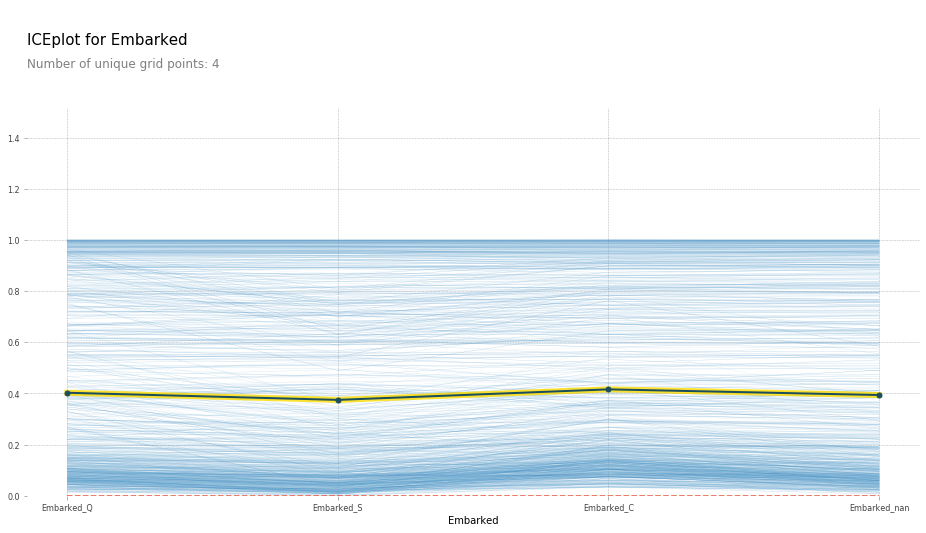

In [89]:
df2.head()
plot_pdp(['Embarked_Q', 'Embarked_S', 'Embarked_C', 'Embarked_nan'],None, 'Embarked')


Here we see a plot which shows the embarkation point made no difference to a passenger's chance of survival

## At this point we have an opportunity to create a new dependent variable from a spotted interaction between two related varables

In [90]:

#df_raw.YearMade[df_raw.YearMade<1950] = 1950
#df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade


In [91]:
df2.describe()

,PassengerId,Pclass,Name,Married,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Sex_nan,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.0,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,446.000000,0.720539,29.361582,0.523008,0.381594,339.528620,32.204208,17.629630,0.352413,0.647587,0.0,0.188552,0.086420,0.722783,0.002245
std,257.353842,0.836071,257.353842,0.448987,13.019697,1.102743,0.806057,200.850657,49.693429,38.140335,0.477990,0.477990,0.0,0.391372,0.281141,0.447876,0.047351
min,1.000000,1.000000,1.000000,0.000000,0.420000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,223.500000,0.000000,22.000000,0.000000,0.000000,159.500000,7.910400,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,446.000000,3.000000,446.000000,1.000000,28.000000,0.000000,0.000000,338.000000,14.454200,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
75%,668.500000,3.000000,668.500000,1.000000,35.000000,1.000000,0.000000,520.500000,31.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000
max,891.000000,3.000000,891.000000,1.000000,80.000000,8.000000,6.000000,681.000000,512.329200,147.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


In [92]:
df_keep.head()


,Sex,Ticket,Fare,Name,Age,Married,Pclass,Cabin
0,2,524,7.2500,109,22.0,1,3,0
1,1,597,71.2833,191,38.0,1,1,82
2,1,670,7.9250,354,26.0,0,3,0
3,1,50,53.1000,273,35.0,1,1,56
4,2,473,8.0500,16,35.0,1,3,0


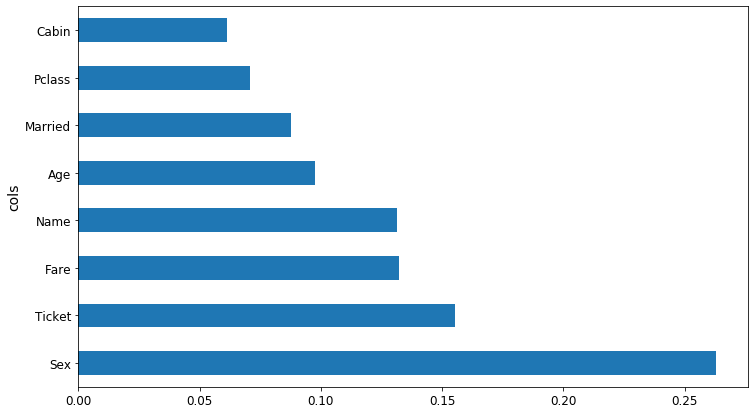

In [93]:
n_trn = len(df_raw) - 100
x_train, x_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features=0.5, n_jobs=-1)
m.fit(x_train, y_train)
plot_fi(rf_feat_importance(m,df_keep))

## Tree Interpreter

Useful for telling why a model has predicted a certain result. 
Tells us how the model makes predictions for an individual row. 

In [94]:
from treeinterpreter import treeinterpreter as ti

In [95]:
df_train, df_valid = split_vals(df_raw [df_keep.columns], n_trn)

In [96]:
passenger = x_valid.values[None,0]
passenger

array([[  2., 140.,  26., 279.,  16.,   1.,   2.,   0.]])

In [97]:
prediction, bias, contributions = ti.predict(m, passenger)

<b>Prediction</b> = predicted dependent variable value for row 

<b>Bias</b> = average value of dependent variable in model


<b>Cointrubutions</b> = causal changes to ouptput for each value of input variable for one passenger


In [98]:
print(f"Prediction {prediction[0]} \nBias {bias}")

Prediction [0.17917] 
Bias [0.391]


In [99]:
indexes = np.argsort(contributions[0])

In [100]:
[o for o in zip(df_keep.columns[indexes], df_valid.iloc[0][indexes], contributions[0][indexes])]

[('Sex', 'male', -0.17520795214676477),
 ('Married', 1, -0.06121586809559261),
 ('Cabin', nan, -0.03322787875658234),
 ('Name', 'Gaskell, Mr. Alfred', -0.016956788771993726),
 ('Fare', 26.0, -0.005869007759570476),
 ('Pclass', 2, -0.0005101948337687612),
 ('Ticket', '239865', 0.02042317873806848),
 ('Age', 16.0, 0.060731178292870884)]

In [101]:
contributions[0].sum()

-0.21183333333333332

This passenger had less chance of surviving since he was male. The rest of the contributions seem insignificant. Perhaps his age would have made more of a predictor if he was under 16.

In [102]:
p_num = 22
passenger= x_valid.values[None,p_num]
passenger

array([[  1.   , 334.   ,  31.275,  24.   ,   6.   ,   0.   ,   3.   ,   0.   ]])

In [103]:
prediction, bias, contributions = ti.predict(m, passenger)

In [104]:
print(f"Prediction {prediction[0]} \nBias {bias}")

Prediction [0.2625] 
Bias [0.391]


In [105]:
indexes = np.argsort(contributions[0])

In [106]:
[o for o in zip(df_keep.columns[indexes], df_valid.iloc[p_num][indexes], contributions[0][indexes])]

[('Fare', 31.275, -0.2876277294133767),
 ('Pclass', 3, -0.13959107151944167),
 ('Ticket', '347082', -0.1022410868491244),
 ('Cabin', nan, -0.01624981125524718),
 ('Name', 'Andersson, Miss. Ebba Iris Alfrida', 0.019921371429651762),
 ('Age', 6.0, 0.08746777874147257),
 ('Married', 0, 0.14937737753663058),
 ('Sex', 'female', 0.16044317132943514)]